This notebook is aiming at organizing outputs from comprehend model and converting the result to Lexicon format

Prerequisite:

1) Output from comprehend model saved locally

2) Testing data meta information saved locally

Output:

1) JSON files containing comprehend outputs in Lexicon format

In [ ]:
# Import required libraries
import pandas as pd
import json
import boto3
import re

In [ ]:
# Load Test data meta information
file_names = pd.read_csv('textract_training_test.csv')['filename'].apply(lambda x: x.rsplit('/')[6]).to_list()
page_list = pd.read_csv('textract_training_test.csv')['page'].to_list()

In [ ]:
# Specify output from Comprehend
comprehend_output_file = 'predictions_keywords.jsonl'

Example of Comprehend Inference output: predictions.jsonl file

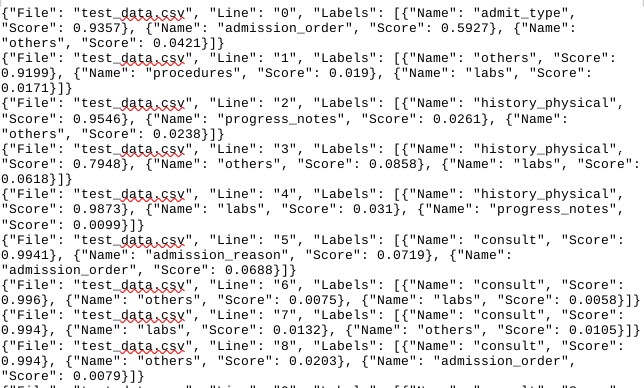

In [ ]:
# Load Comprehend output result, save only prediction with confidence score higher than threshold 
predictions_list = []
with open(comprehend_output_file, encoding = 'utf-8') as lines:
    for f,line, page in zip(file_names,lines, page_list):
        output_line = json.loads(line)
        for k, v in enumerate(output_line['Labels']):
            if v['Score'] > 0.30 :
                output_line['page'] = page
                output_line['class'] = v['Name']
                output_line['FileName'] = f

                predictions_list.append(output_line.copy())

In [ ]:
# Generate Json format output for each PDF file 
seen_list =  []
output_file = []
output_dict = {}
total_dict = {}


for f in predictions_list: 
    
    
    if f['FileName'] not in seen_list:
        seen_list.append(f['FileName'])
    
        total_dict[f['FileName']] = {'FileName' :'' ,'Results' : {}}

        
    output_class = f['class']
    total_dict[f['FileName']]['FileName'] = f['FileName']

    if f['class'] in total_dict[f['FileName']]['Results']:

        total_dict[f['FileName']]['Results'][output_class]['classification_pages'] = total_dict[f['FileName']]['Results'][output_class]['classification_pages'] + ',' + str(f['page'])
                                                                 
    else:

        if f['class'] != 'others':
            total_dict[f['FileName']]['Results'].update({output_class: {'classification_pages' : str(f['page'])}})
                                                                     



In [ ]:
# Save Lexicon Json file to local folder
for f_name in total_dict.keys():
    output_dict = total_dict[f_name]
    with open(f"NONOCR1_downsample/{re.sub('.pdf','',f_name)}.json", 'w') as f:
        json.dump(output_dict,f)